# Overview

## Approach

1. Data
2. Parts
3. Style Transfer Network
4. Super-Resolution Network

In [1]:
%matplotlib inline
import importlib
import utils; importlib.reload(utils)
from utils import *
from vgg16 import preprocess, deprocess, VGG16

Using TensorFlow backend.


Keras fit parameters

In [2]:
parms = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

## 1. Prepare Data

In [3]:
path = './data/'

In [4]:
fnames = glob(path+'**/*.JPEG', recursive=True)
len(fnames)

19440

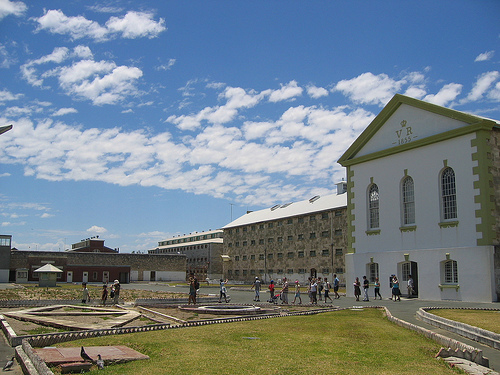

In [5]:
img = Image.open(fnames[777]); img

We load our imagedata and resize it to be 256x256x3 similar to the paper.

CHECK: Input images (x) has to be preprocessed in accordance with VGG16 network (Loss Network)

In [44]:
x = get_batches(path+'train/',target_size=(256, 256), class_mode=None)

Found 19439 images belonging to 774 classes.


## 2. Parts

#### Reflection Padding
The supplementary material mentions the use of reflection padding - implemented as Keras custom layer

In [82]:
class ReflectionPadding2d(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2d, self).__init__(**kwargs)
        
    def compute_output_shape(self, shape):
        return (shape[0], shape[1] + 2 * self.padding[0], shape[2] + 2 * self.padding[1], shape[3])
    
    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0, 0], [h_pad, h_pad], [w_pad, w_pad], [0, 0]], 'REFLECT')

Test of the reflection padding layer

In [ ]:
test_img = np.array(img)

In [ ]:
inp = Input(test_img.shape)
ref_model = Model(inp, ReflectionPadding2d((40, 10))(inp))
ref_model.compile('adam', 'mse')

In [ ]:
test_img = np.expand_dims(test_img, 0); test_img.shape

In [ ]:
pred = ref_model.predict(test_img)

In [ ]:
plt.imshow(pred[0].astype('uint8'))

#### Downsampling (ConvBlock)

Convolutional layers using BatchNormalization and (optional) ReLU activation

In [127]:
def conv_block(x, filters, size=(3,3), strides=(2,2), padding='same', act=True):
    x = Convolution2D(filters, size, strides=strides, padding=padding)(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x) if act else x

#### Upsampling

Method from paper and method from distill paper

##### Deconvolutional Block

In [106]:
def deconv_block(x, filters, size=(3,3), strides=(2,2)):
    x = Deconvolution2D(filters, size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    return Activation('relu')(x)

##### Upsamling Block

In [ ]:
# TODO: implement

#### Residual Blocks

The supplementary material mentions the use of no padding. A 3x3 convolution with no padding reduces the size of a feature map by 1 pixel on each side – the identity connection (ip) performs a center crop on the input feature map.

##### ResBlock - Super-Resolution

In [128]:
def res_block(ip, filters, index=0):
    x = conv_block(ip, filters, strides=(1,1))
    x = conv_block(x, filters, strides=(1,1), act=False)
    return add([x, ip])

##### ResBlock - Style Transfer (no padding)

In [129]:
def res_crop_block(ip, filters, index=0):
    x = conv_block(ip, filters, strides=(1,1), padding='valid')
    x = conv_block(x, filters, strides=(1,1), padding='valid', act=False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return add([x, ip])

## 3. Style Transfer Network

* requires calculation of both `style_loss` and `content_loss`
* style target `y_s`, content target `y_c` and transformed input `y_hat`

In [63]:
batch = x.next()[0]

In [65]:
input_shape = batch[0].shape

### Architecture

In [130]:
inp = Input(input_shape)
x = ReflectionPadding2d((40,40))(inp)
x = conv_block(x, 32, size=(9,9), strides=(1,1))
x = conv_block(x, 64, size=(3,3), strides=(2,2))
x = conv_block(x, 128, size=(3,3), strides=(2,2))
for i in range(5):x = res_crop_block(x, 128, i)
x = deconv_block(x, 64, size=(3,3), strides=(2,2))
x = deconv_block(x, 32, size=(3,3), strides=(2,2))
x = deconv_block(x, 3, size=(9,9), strides=(1,1))

In [131]:
style_model = Model(inp, x)
style_model.compile('adam', 'mse')
style_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_21 (InputLayer)            (None, 256, 256, 3)   0                                            
____________________________________________________________________________________________________
reflection_padding2d_21 (Reflect (None, 336, 336, 3)   0           input_21[0][0]                   
____________________________________________________________________________________________________
conv2d_85 (Conv2D)               (None, 336, 336, 32)  7808        reflection_padding2d_21[0][0]    
____________________________________________________________________________________________________
batch_normalization_109 (BatchNo (None, 336, 336, 32)  128         conv2d_85[0][0]                  
___________________________________________________________________________________________

## 4. Super-Resolution Network

* We're only interested in the `content_loss`
* `yc = x`
* (we need both `x_high_res` and `low x_low_res`)

### Architecture